# CFA for ETS Scale

In [1]:
import pandas as pd
import numpy as np
from scipy.stats import ncx2
import scaledev
import seaborn as sns
import matplotlib.pyplot as plt
from semopy import inspector, Model, Optimizer, semplot, calc_stats, report
from scaledev import preprocessor


In [2]:
data_loc = scaledev.get_data_dir()

# Show full dataframes when printing
pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)
pd.set_option("display.float_format", lambda x: "%.5f" % x)
np.set_printoptions(threshold=100, suppress=True)

# load raw CFA data
df_cfa_raw = pd.read_excel(data_loc / "cfa.xlsx")
df_cfa_raw.head()

# Load the EFA data too, so we have it for comparison
df_efa_raw = pd.read_excel(data_loc / "cleaned_ets.xlsx")

In [3]:
# Start data cleaning
df_cfa = df_cfa_raw.copy()

# Clean up the column names
df_cfa = preprocessor.clean_columns(df_cfa)

# scale items - to use later for filtering down the dataframe
scale_items = [
    c for c in df_cfa.columns if c not in ["frequency", "age", "gender", "ethnicity"]
]

# Create the factor and total scores
df_cfa["inclusion_total"] = df_cfa[
    ["inclusion1", "inclusion2", "inclusion3", "inclusion4", "inclusion5"]
].sum(axis=1)
df_cfa["presence_total"] = df_cfa[
    ["presence1", "presence2", "presence3", "presence4", "presence5", "presence6"]
].sum(axis=1)
df_cfa["embod_total"] = df_cfa[["embod1", "embod2", "embod3", "embod4", "embod5"]].sum(
    axis=1
)
df_cfa["wonder_total"] = df_cfa[["wonder1", "wonder2", "wonder3", "wonder4"]].sum(
    axis=1
)
df_cfa["ets_total"] = df_cfa[scale_items].sum(axis=1)

df_cfa.head()

,inclusion1,inclusion2,inclusion3,inclusion4,inclusion5,presence1,presence2,presence3,presence4,presence5,presence6,embod1,embod2,embod3,embod4,embod5,wonder1,wonder2,wonder3,wonder4,frequency,age,gender,ethnicity,inclusion_total,presence_total,embod_total,wonder_total,ets_total
0,3,3,4,5,3,3,4,4,3,5,5,4,5,4,4,3,4,4,4,4,2,3,1,5,18,24,20,16,78
1,5,5,5,4,4,5,5,4,5,5,4,3,3,3,3,6,4,3,3,4,2,4,3,5,23,28,18,14,83
2,4,5,4,5,4,4,5,5,5,5,4,5,5,5,5,4,3,4,5,4,3,2,1,5,22,28,24,16,90
3,3,3,4,4,3,4,5,4,4,4,4,2,4,4,3,3,3,3,3,4,1,3,3,5,17,25,16,13,71
4,6,6,6,6,6,3,5,3,3,2,2,2,1,1,1,2,5,5,3,2,1,3,3,3,30,18,7,15,70


# Correlations

Text(0.5, 1.0, 'Correlations for items, factors, and total ETS')

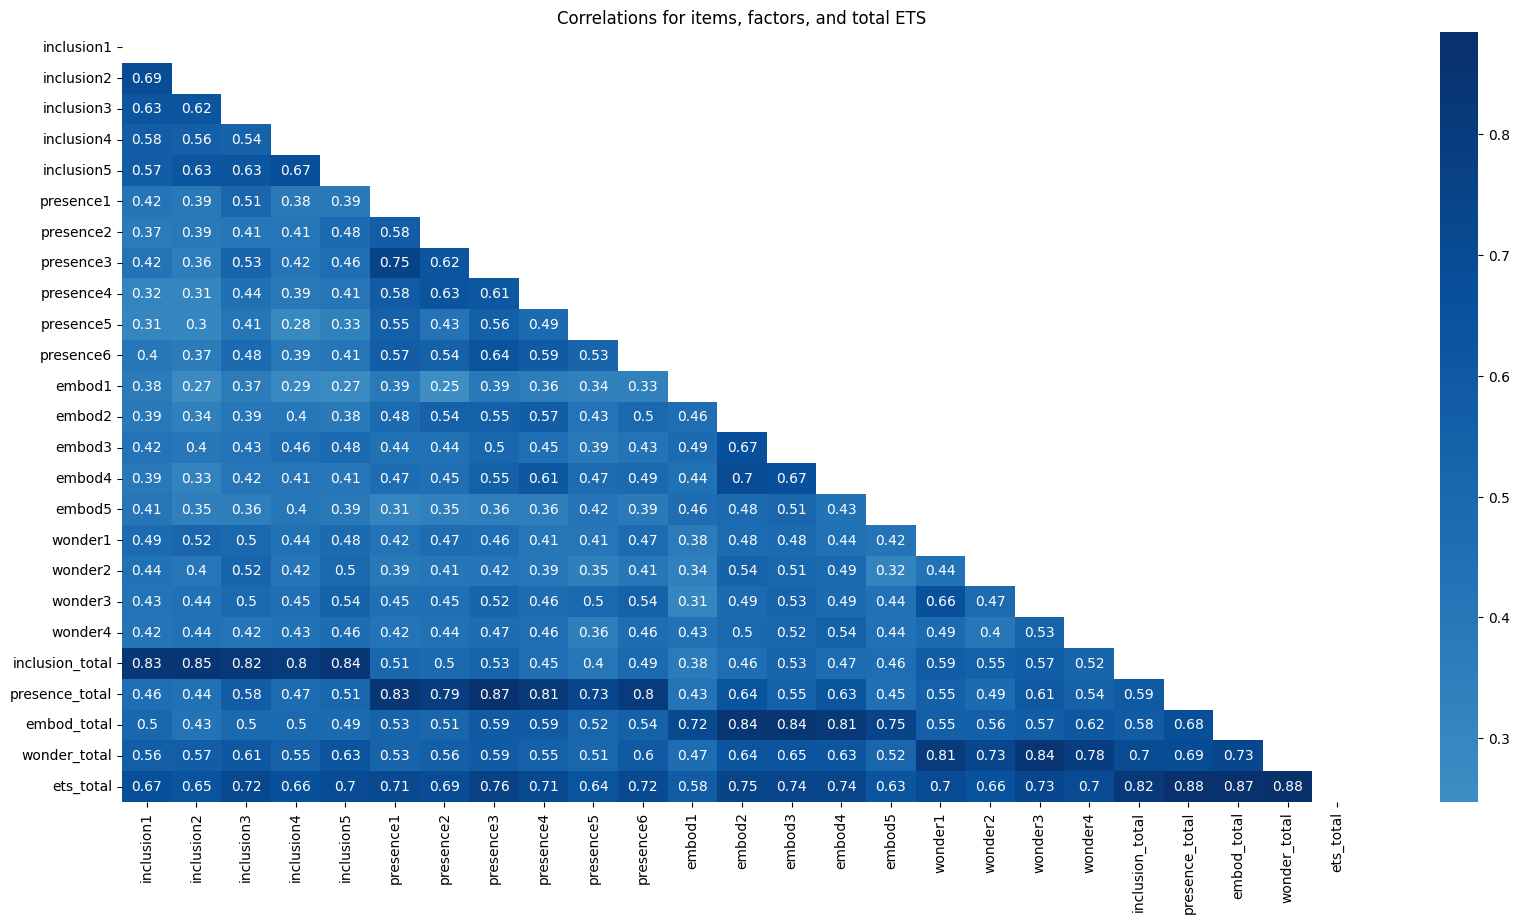

In [4]:
fig, ax = plt.subplots(figsize=(20, 10))
numeric_cols = [
    c for c in df_cfa.columns if c not in ["frequency", "age", "gender", "ethnicity"]
]
corr_df = df_cfa[numeric_cols].corr()
mask = np.triu(np.ones_like(corr_df, dtype=bool))
sns.heatmap(corr_df, annot=True, cmap="Blues", ax=ax, center=0, mask=mask)
ax.set_title("Correlations for items, factors, and total ETS")

# VIF
Variance Inflation Factor is a more robust test for multicollinearity vs just looking at the correlation matrix. The correlation matrix is just pairwise comparisons, but VIF is a multivariate approach, getting at the combined linear relationship between all the other variables. 

In [5]:
# Add a constant term (required for VIF calculation)
df_vif = preprocessor.vif(df_cfa[scale_items])
df_vif

,feature,VIF
0,const,24.68164
1,inclusion1,2.48192
2,inclusion2,2.55387
3,inclusion3,2.53955
4,inclusion4,2.14624
5,inclusion5,2.74938
6,presence1,2.76619
7,presence2,2.34934
8,presence3,3.24570
9,presence4,2.52429


There is moderate multicollinearity here, but that is expected and within acceptable ranges. 

# CFA
CFA requires specifying the model structure upfront, and then seeing if the data fits this specification. It falls under the umbrella of Structural Equation Modeling (SEM). 

In the specification below you will see the note about making the factors uncorrelated. This has to do with this being a bifactor model for CFA. We can talk more about this choice when we meet. 

In [6]:
df_model = df_cfa[scale_items]

model_spec = """
    # General Factor (ETS) - all items load on it
    ETS =~ inclusion1 + inclusion2 + inclusion3 + inclusion4 + inclusion5 + \
            presence1 + presence2 + presence3 + presence4 + presence5 + presence6 + \
            embod1 + embod2 + embod3 + embod4 + embod5 + \
            wonder1 + wonder3
    
    # Specific Factors - items load on their respective factors
    inclusion =~ 1*inclusion1 + inclusion2 + inclusion3 + inclusion4 + inclusion5
    presence =~ 1*presence1 + presence2 + presence3 + presence4 + presence5 + presence6
    embod =~ 1*embod1 + embod2 + embod3 + embod4 + embod5
    wonder =~ 1*wonder1 + wonder3
    
    # General and specific factors are uncorrelated
    ETS ~~ 0*inclusion
    ETS ~~ 0*presence
    ETS ~~ 0*embod
    ETS ~~ 0*wonder

    #The specific factors are also uncorrelated
    inclusion ~~ 0*presence
    inclusion ~~ 0*embod
    inclusion ~~ 0*wonder
    presence ~~ 0*embod
    presence ~~ 0*wonder
    embod ~~ 0*wonder
"""


model = Model(model_spec)
model.fit(
    df_model, solver="L-BFGS-B"
)  # standard solver - best matches what is typically used in SPSS

SolverResult(fun=np.float64(0.9100021916057912), success=True, n_it=68, x=array([0.98979918, 1.17048237, 1.17280182, 0.78777711, 1.04979713,
       0.75950216, 1.12038068, 0.8060323 , 1.19061779, 1.2569198 ,
       0.51313312, 1.37998503, 0.92487225, 1.34543173, 0.48062116,
       1.16016635, 0.43262931, 1.31341102, 0.45006443, 1.01694475,
       1.50560615, 1.60277721, 1.40238466, 1.54505654, 1.42388492,
       1.42872933, 1.33031866, 0.80937418, 1.19591995, 1.3042249 ,
       0.72168449, 0.459937  , 0.42479863, 0.48790185, 0.16372521,
       1.29694914, 0.64602073, 0.64336298, 0.63551357, 1.54364288,
       0.4892792 , 0.46146938, 0.58031823, 0.64821706, 0.52059095,
       0.42565561, 0.76669034, 0.37497774, 0.75744032, 0.92081437,
       0.70538161, 0.31966737, 0.43206244, 0.49990102]), message='CONVERGENCE: RELATIVE REDUCTION OF F <= FACTR*EPSMCH', name_method='L-BFGS-B', name_obj='MLW')

In [7]:
# Calculate fit statistics
fit_stats = calc_stats(model)

# Print the fit statistics
fit_stats

,DoF,DoF Baseline,chi2,chi2 p-value,chi2 Baseline,CFI,GFI,AGFI,NFI,TLI,RMSEA,AIC,BIC,LogLik
Value,117,153,325.78078,0.00000,4026.77147,0.94610,0.91910,0.89420,0.91910,0.92952,0.07070,106.18000,315.72878,0.91000


In [8]:
report(model=model, name="ETS Scale", std_est=True)

In [9]:
stats = calc_stats(model)
rmsea = stats["RMSEA"]
dof = stats["DoF"]  # Degrees of freedom
n = model.n_samples  # Sample size

# Calculate the non-centrality parameter (lambda)
lambda_hat = n * dof * rmsea**2

# Find the lower and upper bounds of the non-centrality parameter
# using the non-central chi-square distribution
alpha = 0.1  # For a 90% CI
lower_lambda = ncx2.ppf(alpha / 2, dof, lambda_hat)
upper_lambda = ncx2.ppf(1 - alpha / 2, dof, lambda_hat)

# Convert the non-centrality parameters back to RMSEA
lower_rmsea = np.sqrt(lower_lambda / (n * dof))
upper_rmsea = np.sqrt(upper_lambda / (n * dof))
# if lower_lambda is 0, lower_rmsea should also be 0
if lower_lambda == 0:
    lower_rmsea = 0

# Corrected printing: Extract the numerical values using .item()
print(f"RMSEA 90% CI (Manual): ({lower_rmsea.item():.3f}, {upper_rmsea.item():.3f})")

RMSEA 90% CI (Manual): (0.081, 0.095)


In [10]:
opt = Optimizer(model)
objective_function_value = opt.optimize()

model_values = inspector.inspect(opt, std_est=True)
model_values
# print(model_values.to_dict())

,lval,op,rval,Estimate,Est. Std,Std. Err,z-value,p-value
0,inclusion1,~,ETS,1.00000,0.57857,-,-,-
1,inclusion1,~,inclusion,1.00000,0.55603,-,-,-
2,inclusion2,~,ETS,0.98980,0.54918,0.08217,12.04642,0.00000
3,inclusion2,~,inclusion,1.17048,0.62413,0.12464,9.39112,0.00000
4,inclusion3,~,ETS,1.17280,0.65456,0.09629,12.17929,0.00000
5,inclusion3,~,inclusion,0.78778,0.42254,0.09835,8.00973,0.00000
6,inclusion4,~,ETS,1.04980,0.60168,0.09279,11.31336,0.00000
7,inclusion4,~,inclusion,0.75950,0.41834,0.10019,7.58061,0.00000
8,inclusion5,~,ETS,1.12038,0.64824,0.09103,12.30811,0.00000
9,inclusion5,~,inclusion,0.80603,0.44819,0.09636,8.36453,0.00000


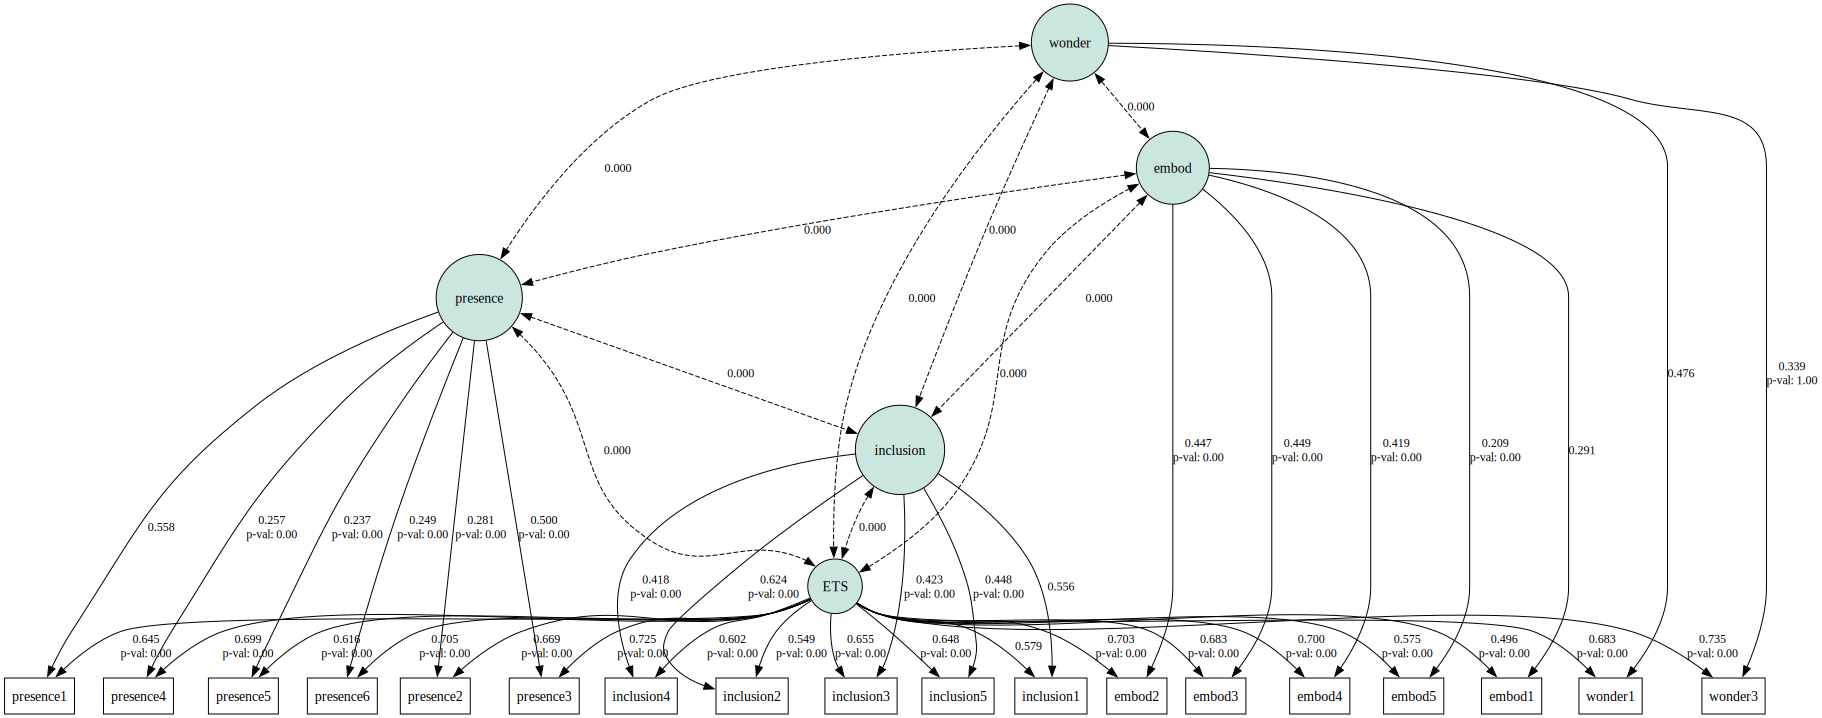

In [11]:
# path diagram
semplot(mod=model, plot_covs=True, std_ests=True, filename="cfa_model_plot.png")